In [85]:
print("Hello world")

Hello world


In [86]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image


In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [88]:
class SemArtDataset(Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform
        self.image_files = dataframe['IMAGE_FILE'].values
        self.labels = dataframe['TYPE'].values
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.base_path, img_name)
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [89]:
# Define transforms: Resize, Normalize and Convert to Tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    
])


In [90]:
train_df = pd.read_csv("data/semart_train.csv", sep="\t", encoding="ISO-8859-1")
train_df["TYPE"].value_counts()

TYPE
religious       7481
portrait        3292
landscape       2490
mythological    1862
genre           1630
still-life       926
historical       545
other            509
interior         452
study             57
Name: count, dtype: int64

In [91]:
def filter_by_start_year(df, start_year=1401):
    """
    Filters a dataframe to include rows where the "TIMEFRAME" column 
    starts from a given year or later.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        start_year (int): The minimum start year for filtering (default is 1401).

    Returns:
        pd.DataFrame: A filtered dataframe.
    """
    # Extract the start year from the TIMEFRAME column
    df["START_YEAR"] = df["TIMEFRAME"].str.split('-').str[0].astype(int)

    # Filter the dataframe based on the start year
    filtered_df = df[df["START_YEAR"] >= start_year]

    # Drop the START_YEAR column (optional)
    filtered_df = filtered_df.drop(columns=["START_YEAR"])

    return filtered_df

In [100]:
# Load CSV files
train_df = pd.read_csv("data/semart_train.csv", sep="\t", encoding="ISO-8859-1")
test_df = pd.read_csv("data/semart_test.csv", sep="\t", encoding="ISO-8859-1")
val_df = pd.read_csv("data/semart_val.csv", sep="\t", encoding="ISO-8859-1")

train_df = filter_by_start_year(train_df, start_year=1401)
val_df = filter_by_start_year(val_df, start_year=1401)
test_df = filter_by_start_year(test_df, start_year=1401)

# Hard-code the classes to focus on: 'religious', 'portrait', 'landscape'
target_classes = ['religious', 'portrait', 'landscape',"still-life","mythological"]

# Filter the DataFrames to include only these three classes
train_df = train_df[train_df['TYPE'].isin(target_classes)]
val_df = val_df[val_df['TYPE'].isin(target_classes)]
test_df = test_df[test_df['TYPE'].isin(target_classes)]

original_class_labels = train_df['TYPE'].unique()

# Reduce dataset size
shrinkage = 1
train_df = train_df.head(len(train_df) // shrinkage)
test_df = test_df.head(len(test_df) // shrinkage)
val_df = val_df.head(len(val_df) // shrinkage)

# Label encoding
le = LabelEncoder()
train_df['TYPE'] = le.fit_transform(train_df['TYPE'])
test_df['TYPE'] = le.transform(test_df['TYPE'])
val_df['TYPE'] = le.transform(val_df['TYPE'])

encoded_to_original = dict(zip(range(len(le.classes_)), le.classes_))

# Load dataset
base_path = 'processed_imagesV2/'
train_dataset = SemArtDataset(train_df, base_path, transform=transform)
val_dataset = SemArtDataset(val_df, base_path, transform=transform)
test_dataset = SemArtDataset(test_df, base_path, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [93]:
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(28*28, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10),
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits
    
#     next(iter(train_loader))[0].shape

In [109]:
# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True) #Was True 

# Freeze the layers of VGG16 (optional for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer (classifier) with a new one for our dataset
num_classes = len(np.unique(train_df['TYPE']))  # Number of classes in the dataset
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Move model to device (GPU or CPU)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001) 

#When you have network train your model with 2 images. Loss needs to go 0.0. We expect our model to ourfit. 
#overfit test

#It is too slow, it will crep to go 0.0. 

#overfit on at least 1 samlple, but our goal isn't to overfit.

#Should always try out





#Default 0.001
#zelfde idee als SGD; lr is learning rate


#drop outs uitproberen

d:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from tqdm import tqdm  # Import tqdm
import matplotlib.pyplot as plt
import datetime
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader

#Optimal nodes in the fully connected

# Define the model
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Reduces spatial dimensions to a vector
        self.fc1 = nn.Linear(512, 128)  # Assuming 512 is the output size of the previous layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

num_classes = len(np.unique(y_train))
model = CustomModel(num_classes=num_classes)

naam = f"{datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')}_BestModel"

# Training Loop with Tracking
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_validation_loss = np.inf

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    # Wrap the train_loader with tqdm for progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch") as progress_bar:
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device).long()  # Cast labels to torch.long

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
            
            # Update the progress bar description
            progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1), accuracy=correct_preds / total_preds)
    
    # Calculate training loss and accuracy
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_accuracy = correct_preds / total_preds
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.4f}")
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct_preds = 0
    val_total_preds = 0

    with torch.no_grad():
        with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch") as val_bar:
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device).long()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Track loss and accuracy
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)

                # Update validation progress bar
                val_bar.set_postfix(loss=val_running_loss / (val_bar.n + 1), accuracy=val_correct_preds / val_total_preds)

    # Calculate validation loss and accuracy
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = val_correct_preds / val_total_preds
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    #Doe accurracy ipv
    if val_epoch_loss < best_validation_loss:
        print("New best model")
        best_validation_loss = val_epoch_loss
        torch.save(model.state_dict(), f'trainedmodels\\{naam}.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()

plt.savefig(f"trainedmodels\\{naam}.png", dpi=300)

plt.show()


Epoch 1/10 - Training: 100%|██████████| 464/464 [02:08<00:00,  3.62batch/s, accuracy=0.689, loss=0.846]


Epoch [1/10], Training Loss: 0.8461, Training Accuracy: 0.6887


Epoch 1/10 - Validation: 100%|██████████| 26/26 [00:06<00:00,  4.21batch/s, accuracy=0.744, loss=0.663]


new best model
Epoch [1/10], Validation Loss: 0.6629, Validation Accuracy: 0.7438


Epoch 2/10 - Training: 100%|██████████| 464/464 [02:07<00:00,  3.63batch/s, accuracy=0.753, loss=0.667]


Epoch [2/10], Training Loss: 0.6668, Training Accuracy: 0.7535


Epoch 2/10 - Validation: 100%|██████████| 26/26 [00:06<00:00,  4.11batch/s, accuracy=0.764, loss=0.617]


new best model
Epoch [2/10], Validation Loss: 0.6171, Validation Accuracy: 0.7636


Epoch 3/10 - Training: 100%|██████████| 464/464 [01:58<00:00,  3.91batch/s, accuracy=0.765, loss=0.631]


Epoch [3/10], Training Loss: 0.6314, Training Accuracy: 0.7650


Epoch 3/10 - Validation: 100%|██████████| 26/26 [00:07<00:00,  3.69batch/s, accuracy=0.771, loss=0.586]


new best model
Epoch [3/10], Validation Loss: 0.5857, Validation Accuracy: 0.7710


Epoch 4/10 - Training: 100%|██████████| 464/464 [02:15<00:00,  3.42batch/s, accuracy=0.77, loss=0.613] 


Epoch [4/10], Training Loss: 0.6129, Training Accuracy: 0.7696


Epoch 4/10 - Validation: 100%|██████████| 26/26 [00:06<00:00,  3.97batch/s, accuracy=0.774, loss=0.59] 


Epoch [4/10], Validation Loss: 0.5902, Validation Accuracy: 0.7735


Epoch 5/10 - Training: 100%|██████████| 464/464 [02:04<00:00,  3.74batch/s, accuracy=0.775, loss=0.601]


Epoch [5/10], Training Loss: 0.6013, Training Accuracy: 0.7754


Epoch 5/10 - Validation: 100%|██████████| 26/26 [00:06<00:00,  3.73batch/s, accuracy=0.78, loss=0.567] 


new best model
Epoch [5/10], Validation Loss: 0.5675, Validation Accuracy: 0.7797


Epoch 6/10 - Training: 100%|██████████| 464/464 [02:03<00:00,  3.77batch/s, accuracy=0.774, loss=0.596]


Epoch [6/10], Training Loss: 0.5962, Training Accuracy: 0.7742


Epoch 6/10 - Validation: 100%|██████████| 26/26 [00:06<00:00,  3.91batch/s, accuracy=0.774, loss=0.564]


new best model
Epoch [6/10], Validation Loss: 0.5636, Validation Accuracy: 0.7735


Epoch 7/10 - Training: 100%|██████████| 464/464 [02:04<00:00,  3.72batch/s, accuracy=0.78, loss=0.586] 


Epoch [7/10], Training Loss: 0.5862, Training Accuracy: 0.7799


Epoch 7/10 - Validation: 100%|██████████| 26/26 [00:06<00:00,  3.92batch/s, accuracy=0.783, loss=0.555]


new best model
Epoch [7/10], Validation Loss: 0.5550, Validation Accuracy: 0.7834


Epoch 8/10 - Training: 100%|██████████| 464/464 [02:04<00:00,  3.73batch/s, accuracy=0.783, loss=0.584]


Epoch [8/10], Training Loss: 0.5844, Training Accuracy: 0.7829


Epoch 8/10 - Validation: 100%|██████████| 26/26 [00:06<00:00,  3.80batch/s, accuracy=0.776, loss=0.566]


Epoch [8/10], Validation Loss: 0.5658, Validation Accuracy: 0.7760


Epoch 9/10 - Training: 100%|██████████| 464/464 [02:05<00:00,  3.70batch/s, accuracy=0.785, loss=0.573]


Epoch [9/10], Training Loss: 0.5725, Training Accuracy: 0.7849


Epoch 9/10 - Validation: 100%|██████████| 26/26 [00:07<00:00,  3.71batch/s, accuracy=0.79, loss=0.555] 


new best model
Epoch [9/10], Validation Loss: 0.5547, Validation Accuracy: 0.7896


Epoch 10/10 - Training: 100%|██████████| 464/464 [02:02<00:00,  3.79batch/s, accuracy=0.787, loss=0.57] 


Epoch [10/10], Training Loss: 0.5704, Training Accuracy: 0.7867


Epoch 10/10 - Validation: 100%|██████████| 26/26 [00:06<00:00,  3.95batch/s, accuracy=0.785, loss=0.548]


new best model
Epoch [10/10], Validation Loss: 0.5484, Validation Accuracy: 0.7847


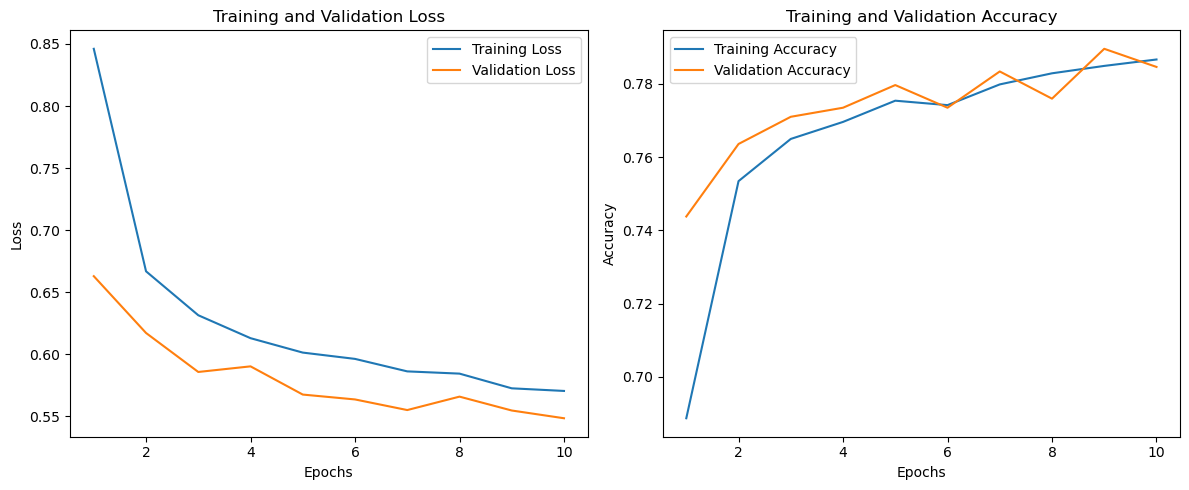

In [110]:
from tqdm import tqdm  # Import tqdm
import matplotlib.pyplot as plt
import datetime

naam = f"{datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")}_BestModel"

# Training Loop with Tracking
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_validation_loss = np.inf

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    # Wrap the train_loader with tqdm for progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch") as progress_bar:
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device).long()  # Cast labels to torch.long

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
            
            # Update the progress bar description
            progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1), accuracy=correct_preds / total_preds)
    
    # Calculate training loss and accuracy
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_accuracy = correct_preds / total_preds
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.4f}")
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct_preds = 0
    val_total_preds = 0

    with torch.no_grad():
        with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch") as val_bar:
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device).long()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Track loss and accuracy
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)

                # Update validation progress bar
                val_bar.set_postfix(loss=val_running_loss / (val_bar.n + 1), accuracy=val_correct_preds / val_total_preds)

    # Calculate validation loss and accuracy
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = val_correct_preds / val_total_preds
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)


    #hoogste opslaan Doe accuracy
    if val_epoch_loss<best_validation_loss:
        print("new best model")
        best_validation_loss = val_epoch_loss
        torch.save(model, f'trainedmodels\\{naam}.pth')



    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()

plt.savefig(f"trainedmodels\\{naam}.png", dpi=300)

plt.show()


#with augmentation: training loss will go down slower. "Learn slower learn better"

In [ ]:
# Evaluate the model on the validation and test set
model = torch.load('trainedmodels\\2025_01_09_12_17_BestModel.pth')  # Load your trained model
model.to(device)  # Ensure the model is on the correct device

model.eval()
correct_preds = 0
total_preds = 0

# Evaluate on validation set
for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

val_accuracy = correct_preds / total_preds
print(f"Validation accuracy: {val_accuracy:.4f}")

# Evaluate on test set
correct_preds = 0
total_preds = 0

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_accuracy = correct_preds / total_preds
print(f"Test accuracy: {test_accuracy:.4f}")


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17400\1817500465.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('2025_01_09_12_17_BestModel.pth')  # 

Validation accuracy: 0.8438
Test accuracy: 0.8182


In [99]:
plt.savefig(f"trainedmodels\\{naam}.png", dpi=300)

<Figure size 640x480 with 0 Axes>

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17400\756352672.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('2025_01_09_10_32_BestModel.pth')  # L

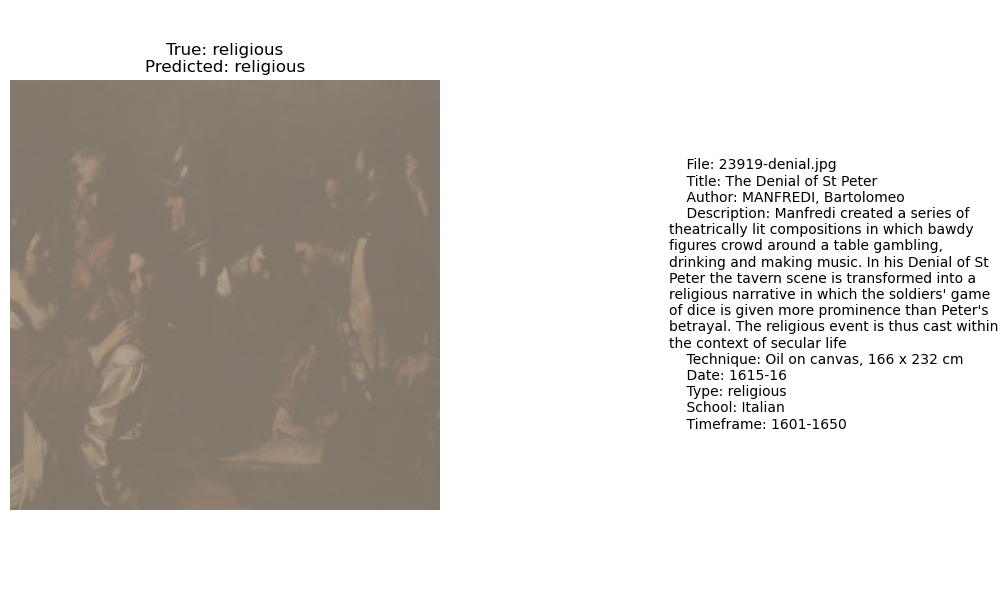

In [48]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random

# Define mean and std used during normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

model = torch.load('2025_01_09_12_17_BestModel.pth')  # Load your trained model
model.to(device)  # Ensure the model is on the correct device

# Evaluate a single batch from test_loader
model.eval()

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    # Move the inputs and labels back to CPU for visualization
    inputs = inputs.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    # Randomly select an index from the current batch
    random_index = random.randint(0, len(inputs) - 1)
    image = inputs[random_index]  # Get a random image in the batch
    label = labels[random_index].item()
    prediction = predicted[random_index].item()

    # Retrieve metadata from the dataset's DataFrame
    metadata = test_loader.dataset.dataframe.iloc[random_index]
    image_file = metadata["IMAGE_FILE"]
    description = metadata["DESCRIPTION"]
    author = metadata["AUTHOR"]
    title = metadata["TITLE"]
    technique = metadata["TECHNIQUE"]
    date = metadata["DATE"]
    type_ = encoded_to_original[metadata["TYPE"]]
    school = metadata["SCHOOL"]
    timeframe = metadata["TIMEFRAME"]
    timeframe = metadata["TIMEFRAME"]

    # Undo normalization for visualization (if normalization was applied during preprocessing)
    unnormalized_image = image.clone()
    for t, m, s in zip(unnormalized_image, mean, std):
        t.mul_(s).add_(m)  # Scale by std and add mean

    # Convert tensor to numpy for matplotlib
    image_np = unnormalized_image.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format

    # Plot the image and metadata
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.axis("off")
    plt.title(f"True: {encoded_to_original[label]}\nPredicted: {encoded_to_original[prediction]}")

    # Display metadata next to the image
    plt.subplot(1, 2, 2)
    metadata_text = f"""
    File: {image_file}
    Title: {title}
    Author: {author}
    Description: {description}
    Technique: {technique}
    Date: {date}
    Type: {type_}
    School: {school}
    Timeframe: {timeframe}
    """
    plt.text(0.5, 0.5, metadata_text, fontsize=10, wrap=True, verticalalignment="center", horizontalalignment="left")
    plt.axis("off")

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Break after processing one batch
    break



C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17400\3967019825.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('trainedmodels\\2025_01_09_13_28_Bes

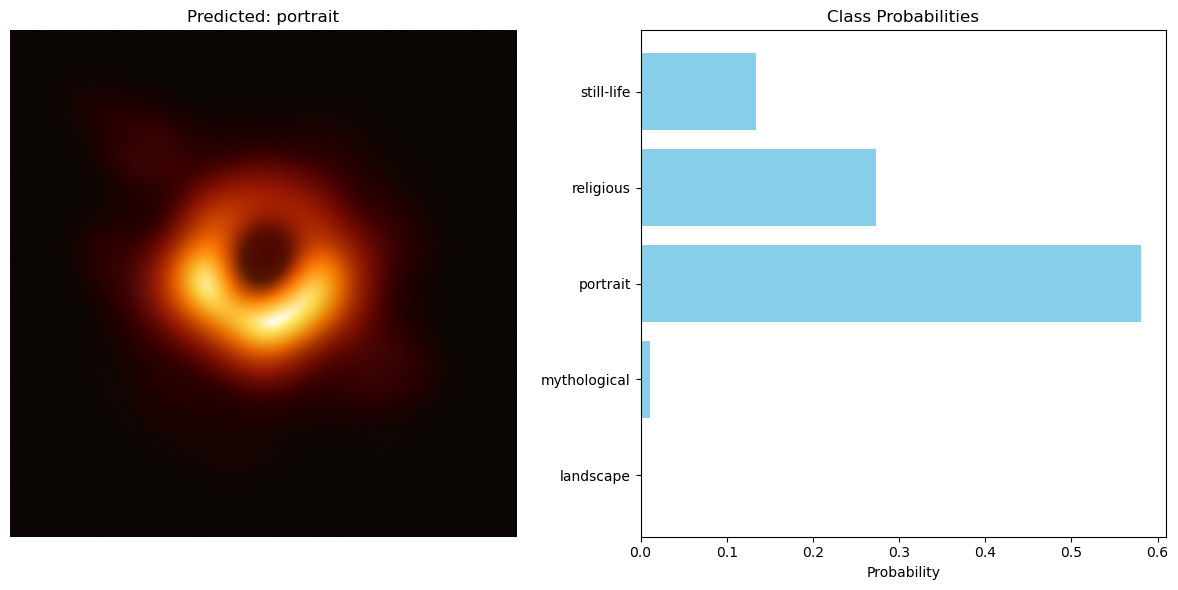

Predicted class: portrait


In [150]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define the transformation pipeline (same as used in training)
transform_pipeline = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.CenterCrop((224, 224)),  # Resize the image to match input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define the original class labels as per the encoding
original_class_labels = encoded_to_original

# Function to upload image, preprocess, and predict
def predict_image_with_probabilities(image_path, model, device):
    # Open the image
    image = Image.open(image_path).convert("RGB")  # Ensure it is RGB

    # Apply transformations
    image_tensor = transform_pipeline(image).unsqueeze(0)  # Add batch dimension

    # Move the image tensor to the device
    image_tensor = image_tensor.to(device)

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Pass the image through the model
        outputs = model(image_tensor)
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1).cpu().numpy().squeeze()

    # Get the predicted label
    predicted_index = torch.argmax(outputs, dim=1).item()
    predicted_class = original_class_labels[predicted_index]

    # Plot the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")

    # Plot the probabilities
    plt.subplot(1, 2, 2)
    classes = [original_class_labels[i] for i in range(len(probabilities))]
    plt.barh(classes, probabilities, color="skyblue")
    plt.xlabel("Probability")
    plt.title("Class Probabilities")
    plt.tight_layout()

    plt.show()

    return predicted_class

# Example usage:
image_path = "zwartgat.jpg"  # Specify the image file path processed_imagesV2\\


# Load the pre-trained model (assuming it's already trained)
model = torch.load('trainedmodels\\2025_01_09_13_28_BestModel.pth')  # Load your trained model
model.to(device)  # Ensure the model is on the correct device

# Run the prediction on the uploaded image
predicted_class = predict_image_with_probabilities(image_path, model, device)
print(f"Predicted class: {predicted_class}")


In [105]:
encoded_to_original

{0: 'landscape',
 1: 'mythological',
 2: 'portrait',
 3: 'religious',
 4: 'still-life'}